## Introduction

The task is to build a GAN model that generates 7,000 to 10,000 Monet-style images. A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

The dataset has 300 Monet paintes sized 256x256 in both JPEG and TFRecord format. There are 7038 photos that could be transform to Monet-style art sized 256x256 available in both JPEG and TFRecord formats. The output file is **images.zip** which contains 7,000 to 10,000 images sized 256x256.

Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID). The smaller MiFID is, the better your generated images are.

In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-t36xnmo6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-t36xnmo6
  Resolved https://github.com/tensorflow/examples.git to commit 652ee34ff046946c36b8aed5d97ecebab0699f7e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1734446297.577653703822934887080861169866359378810363289470-py3-none-any.whl size=301604 sha256=8da984e85ca252797381d01d39171a4c7deba04434f37436b6245004de1ac3c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vgcyxqxz/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import time
from IPython.display import clear_output

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.17.0


In [3]:
GCS_PATH = '/kaggle/input/gan-getting-started'
os.listdir(GCS_PATH)

['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']

## Loading Data From TFRecords

Tensorflow’s own binary storage format. Binary data takes up less space on disk, takes less time to copy and can be read much more efficiently from disk. It makes it easy to combine multiple datasets and integrates seamlessly with the data import and preprocessing functionality provided by the library. 

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [4]:
# tf.io.gfile.glob allows you to search for files matching a specific pattern
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

MONET_jpg = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet JPG Files:', len(MONET_jpg))

PHOTO_jpg = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Photo JPG Files:', len(PHOTO_jpg))

Monet TFRecord Files: 5
Photo TFRecord Files: 20
Monet JPG Files: 300
Photo JPG Files: 7038


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # normalizing the image to [-1, 1] for each RGB value
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    # a dictionary defines the features in TFRecord file
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    # creates a dataset from TFRecord file
    dataset = tf.data.TFRecordDataset(filenames)
    # apply read_tfrecord function to each eltment in the dataset, extracting the features according to the schema.
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [7]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [8]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's visualize a photo example and a Monet example

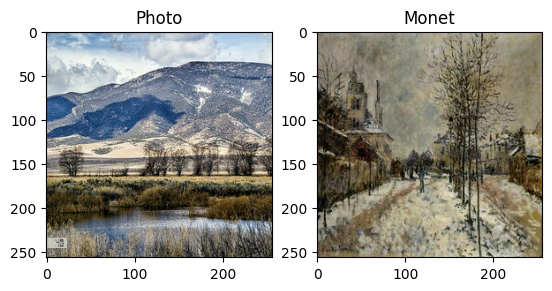

In [9]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [10]:
print("Dimension of Monet Images: ", example_monet[0].shape)
print("Dimension of Photo: ", example_photo[0].shape)

Dimension of Monet Images:  (256, 256, 3)
Dimension of Photo:  (256, 256, 3)


The image has 256x256 pixels and RGB channels

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in Pix2Pix via the installed tensorflow_examples package.

This model uses instance normalization and a modified unet generator. There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

* Generator G learns to transform image X to image Y. 
* Generator F learns to transform image Y to image X. 
* Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
* Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

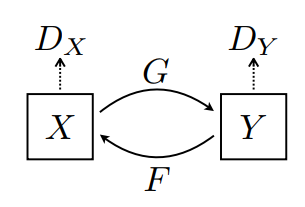
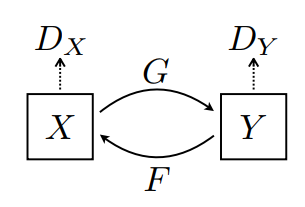

In [11]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

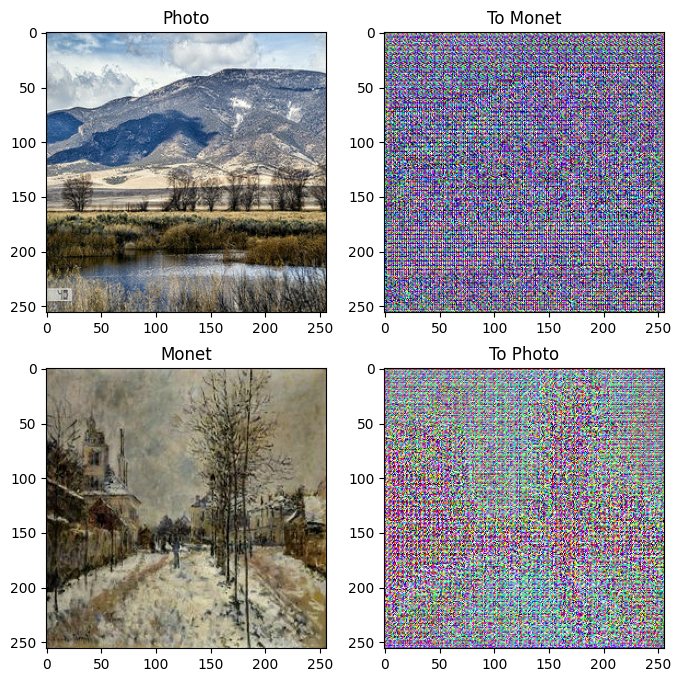

In [12]:
to_monet = generator_g(example_photo)
to_photo = generator_f(example_monet)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [example_photo, to_monet, example_monet, to_photo]
title = ['Photo', 'To Monet', 'Monet', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

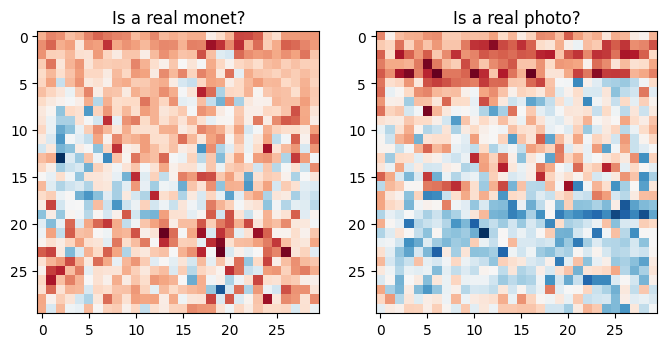

In [13]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real monet?')
plt.imshow(discriminator_y(example_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_x(example_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss Functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [14]:
LAMBDA = 10

In [15]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [17]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,

* Image $X$  is passed via generator $G$ that yields generated image $\hat{Y}$
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$
* Mean absolute error is calculated between $X$  and $\hat{X}$

* forward cycle consistency loss: $X -> G(X) -> F(G(X)) \sim \hat{X}$
* backward cycle consistency loss: $Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$

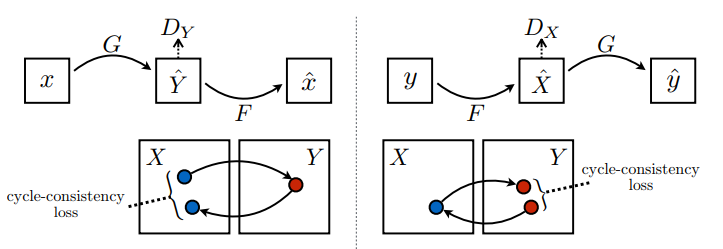
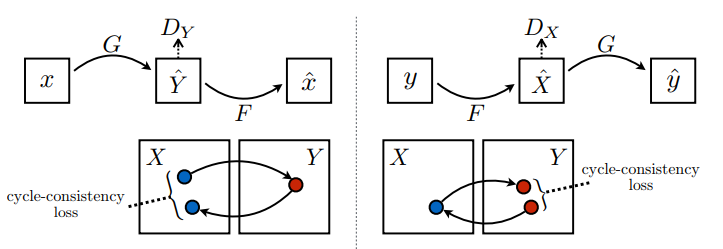

In [18]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$
, it should yield the real image $Y$  or something close to image $Y$.

If you run the photo-to-monet model on a monet drawing or the monet-to-photo model on a photo, it should not modify the image much since the image already contains the target class.

$Identity_loss= |G(Y) - Y| + |F(X) - X|$

In [19]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [20]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [21]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Train the Model

In [22]:
EPOCHS = 10

In [23]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [24]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

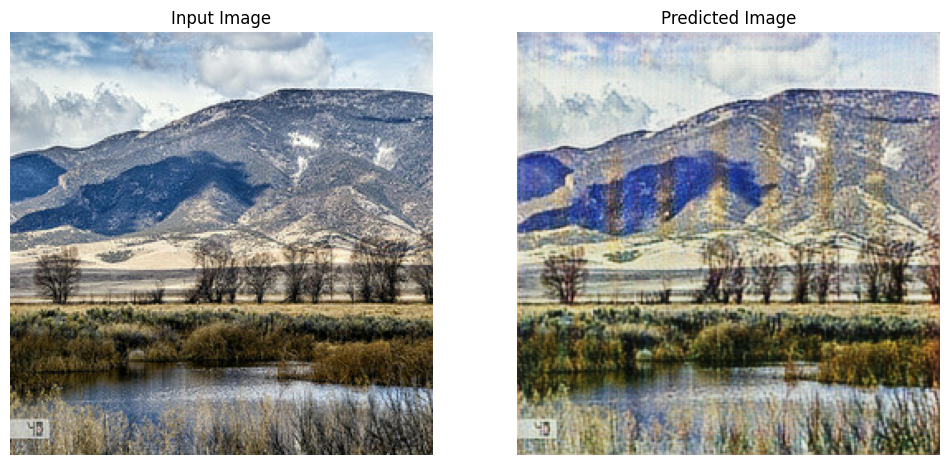

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 77.09070801734924 sec



In [25]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (example_photo) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, example_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Create Submission File

In [26]:
import PIL
# os.mkdir('images')
! mkdir ../images

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
i = 1
for img in photo_ds:
    prediction = generator_g(img)
    prediction = prediction.numpy()
    # Remove the batch dimension
    prediction = np.squeeze(prediction, axis=0)
    # print(prediction.shape)
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [28]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Reference
* https://www.kaggle.com/code/stealthknight/monet-cyclegan-tutorial
* https://www.tensorflow.org/tutorials/generative/cyclegan#loss_functions
* https://www.tensorflow.org/tutorials/generative/pix2pix#build_an_input_pipeline_with_tfdata